# SIMPLE solver for 2D dimensionless incompressible NS Equations

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
import os

In [7]:
from numpy.core.numeric import ones_like
# Derive convection diffusion solver class
class SIMPLESolver():
# Nested classes
    class icbc():
        def __init__(self, uBD, vBD):
            self.uL = uBD[0]
            self.uR = uBD[1]
            self.uT = uBD[2]
            self.uB = uBD[3]
            self.vL = vBD[0]
            self.vR = vBD[1]
            self.vT = vBD[2]
            self.vB = vBD[3]
    class mesh():
        def __init__(self, meshX, meshY):
            self.gridx = meshX
            self.gridy = meshY
            self.dx = meshX[0,1] - meshX[0,0]
            self.dy = meshY[1,0] - meshY[0,0]
            self.xc = (meshX + 0.5 * self.dx)[:-1,:-1]
            self.yc = (meshY + 0.5 * self.dy)[:-1,:-1]
            self.nxc = len(meshX[0,:]) - 1
            self.nyc = len(meshX[:,0]) - 1
    class Sol():
        def __init__(self, cell_grid):
            self.U = np.zeros_like(cell_grid)
            self.V = np.zeros_like(cell_grid)
            self.P = np.zeros_like(cell_grid)
            self.exact = np.zeros((2,cell_grid.shape[0]))
            self.InitResiduals = [[],[],[]]
            self.residuals = [[],[],[]]

# Constructor
    def __init__(self, meshX=None, meshY=None, schm=None, bc=None, lim=None, u0=None, uBD=None, vBD=None, Gamma=None, rho=None, simple_param=None, tol=None, case=None):
        self.icbc = self.icbc(uBD, vBD)
        self.mesh = self.mesh(meshX, meshY)
        self.bctype = bc
        self.case = case
        self.schm = schm
        self.lim = lim
        self.Gamma = Gamma
        self.rho = rho
        self.convergency = False
        self.tol = tol
        self.iter_UV = simple_param[0]
        self.iter_P = simple_param[1]
        self.outloop_max = simple_param[2]
        self.tol_UV = simple_param[3]
        self.tol_P = simple_param[4]
        self.alpha = simple_param[5] # damping coefficient for solving u and v momentum equations
        self.relax_factor_UV = simple_param[6]
        self.relax_factor_P = simple_param[7]
        if (u0 is None):
            self.initialize()
        self.Sol = self.Sol(self.mesh.xc)

    # SIMPLE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    def solve(self):
        i = 0
        while (not ((self.convergency and i > 10) or i > self.outloop_max)):
        # for i in range(5):
            print('Outer loop: ', i)
            self.updateDPF()
            self.calc_link_coef_UV(self.U, self.U_aW, self.U_aE, self.U_aS, self.U_aN, self.U_aP, self.U_Du, self.U_Pu, self.U_Fu, self.U_Dv, self.U_Pv, self.U_Fv)
            self.calc_link_coef_UV(self.V, self.V_aW, self.V_aE, self.V_aS, self.V_aN, self.V_aP, self.V_Du, self.V_Pu, self.V_Fu, self.V_Dv, self.V_Pv, self.V_Fv)
            self.solve_momentum('U-Eqn', self.U, self.U_aW, self.U_aE, self.U_aS, self.U_aN, self.U_aP, self.icbc.uL, self.icbc.uR, self.icbc.uT, self.icbc.uB, self.pGrad_U, self.Sol.InitResiduals[0], self.Sol.residuals[0])
            self.solve_momentum('V-Eqn', self.V, self.V_aW, self.V_aE, self.V_aS, self.V_aN, self.V_aP, self.icbc.vL, self.icbc.vR, self.icbc.vT, self.icbc.vB, self.pGrad_V,  self.Sol.InitResiduals[1], self.Sol.residuals[1])
            
            self.calc_link_coef_P(self.P, self.P_aW, self.P_aE, self.P_aS, self.P_aN, self.P_aP)
            self.solve_pressure_correction(self.P_corr, self.P_aW, self.P_aE, self.P_aS, self.P_aN, self.P_aP, self.calc_continuity_error, self.Sol.InitResiduals[2], self.Sol.residuals[2])
            
            self.update_UVP()
            self.check_convergency()
            i += 1
        # The final step:
        self.collect_results()
    # SIMPLE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

    def initialize(self):
        ny = self.mesh.nyc
        nx = self.mesh.nxc
        self.P = np.zeros((ny, nx))
        self.P_corr = np.zeros_like(self.P)
        self.continuity_error = np.zeros_like(self.P)
        self.U = np.zeros((ny, nx-1))
        self.V = np.zeros((ny-1, nx))
        u_nx = self.U.shape[1]
        u_ny = self.U.shape[0]
        v_nx = self.V.shape[1]
        v_ny = self.V.shape[0]
        self.U_Fu = np.zeros((u_ny, u_nx + 1))
        self.U_Fv = np.zeros((u_ny+1, u_nx))
        self.V_Fu = np.zeros((v_ny, v_nx + 1))
        self.V_Fv = np.zeros((v_ny + 1, v_nx))
        self.U_aW = np.zeros_like(self.U)
        self.U_aE = np.zeros_like(self.U_aW)
        self.U_aS = np.zeros_like(self.U_aW)
        self.U_aN = np.zeros_like(self.U_aW)
        self.U_aP = np.zeros_like(self.U_aW)
        self.V_aW = np.zeros_like(self.V)
        self.V_aE = np.zeros_like(self.V_aW)
        self.V_aS = np.zeros_like(self.V_aW)
        self.V_aN = np.zeros_like(self.V_aW)
        self.V_aP = np.zeros_like(self.V_aW)
        self.P_aW = np.zeros_like(self.P)
        self.P_aE = np.zeros_like(self.P_aW)
        self.P_aS = np.zeros_like(self.P_aW)
        self.P_aN = np.zeros_like(self.P_aW)
        self.P_aP = np.zeros_like(self.P_aW)
        # D term
        self.U_Du = self.Gamma * np.ones_like(self.U_Fu) / self.mesh.dx * self.mesh.dy # Assume dCell = dGrid
        self.U_Dv = self.Gamma * np.ones_like(self.U_Fv) / self.mesh.dy * self.mesh.dx # Assume dCell = dGrid
        self.U_Dv[0,:] *= 2.0 # delta_y = 0.5 * delta_y, due to the effect of the zero volume cell
        self.U_Dv[-1,:] *= 2.0 # delta_y = 0.5 * delta_y, due to the effect of the zero volume cell
        self.V_Du = self.Gamma * np.ones_like(self.V_Fu) / self.mesh.dx * self.mesh.dy # Assume dCell = dGrid
        self.V_Dv = self.Gamma * np.ones_like(self.V_Fv) / self.mesh.dy * self.mesh.dx # Assume dCell = dGrid
        self.V_Du[:,0] *= 2.0 # delta_x = 0.5 * delta_x, due to the effect of the zero volume cell
        self.V_Du[:,-1] *= 2.0 # delta_x = 0.5 * delta_x, due to the effect of the zero volume cell


    def update_UVP(self):
        nx = self.U.shape[1]
        ny = self.U.shape[0]
        for j in range(ny):
            for i in range(nx):
                self.U[j,i] += self.du[j,i] * (self.P_corr[j,i] - self.P_corr[j,i+1]) * self.relax_factor_UV
        nx = self.V.shape[1]
        ny = self.V.shape[0]
        for j in range(ny):
            for i in range(nx):
                self.V[j,i] += self.dv[j,i] * (self.P_corr[j,i] - self.P_corr[j+1,i]) * self.relax_factor_UV
        self.P += self.P_corr * self.relax_factor_P 

    def updateDPF(self):       
        ny = self.mesh.nyc
        nx = self.mesh.nxc
        # F term
        for j in range(ny):
            for i in range(nx):
                if i == 0:
                    self.U_Fu[j,i] = 0.5 * (self.icbc.uL + self.U[j,i])
                elif i == nx-1:
                    self.U_Fu[j,i] = 0.5 * (self.U[j,i-1] + self.icbc.uR)
                else:
                    self.U_Fu[j,i] = 0.5 * (self.U[j,i-1] + self.U[j,i])
        for j in range(ny+1):
            for i in range(nx-1):
                if j == 0:
                    self.U_Fv[j,i] = self.icbc.vB
                elif j == ny + 1 - 1:
                    self.U_Fv[j,i] = self.icbc.vT
                else:
                    self.U_Fv[j,i] = 0.5 * (self.V[j-1,i] + self.V[j-1,i+1])
        for j in range(ny-1):
            for i in range(nx+1):
                if i == 0:
                    self.V_Fu[j,i] = self.icbc.uL
                elif i == nx + 1 - 1:
                    self.V_Fu[j,i] = self.icbc.uR
                else:
                    self.V_Fu[j,i] = 0.5 * (self.U[j,i-1] + self.U[j+1,i-1])
        for j in range(ny):
            for i in range(nx):
                if j == 0:
                    self.V_Fv[j,i] = 0.5 * (self.icbc.vB + self.V[j,i])
                elif j == ny - 1:
                    self.V_Fv[j,i] = 0.5 * (self.V[j-1,i] + self.icbc.vT)
                else:
                    self.V_Fv[j,i] = 0.5 * (self.V[j-1,i] + self.V[j,i])
        # P term
        self.U_Pu = np.divide(self.U_Fu, self.U_Du)
        self.U_Pv = np.divide(self.U_Fv, self.U_Dv)
        self.V_Pu = np.divide(self.V_Fu, self.V_Du)
        self.V_Pv = np.divide(self.V_Fv, self.V_Dv)

    def calc_link_coef_UV(self, phi, aW, aE, aS, aN, aP, Du, Pu, Fu, Dv, Pv, Fv):
        nx = phi.shape[1]
        ny = phi.shape[0]
        for j in range(ny):
            for i in range(nx):
                aW[j,i] = self.calc_aW_(Du, Pu, Fu, j, i)
                aE[j,i] = self.calc_aE_(Du, Pu, Fu, j, i)
                aS[j,i] = self.calc_aS_(Dv, Pv, Fv, j, i)
                aN[j,i] = self.calc_aN_(Dv, Pv, Fv, j, i)
                aP[j,i] = aW[j,i] + aE[j,i] + aS[j,i] + aN[j,i]

    def calc_link_coef_P(self, phi, aW, aE, aS, aN, aP):
        nx = phi.shape[1]
        ny = phi.shape[0]
        self.du = np.divide(self.mesh.dy, self.U_aP)
        self.dv = np.divide(self.mesh.dx, self.V_aP)
        for j in range(ny):
            for i in range(nx):
                aW[j,i] = self.calc_aW_P(nx, ny, self.rho, self.du, self.mesh.dy, j, i)
                aE[j,i] = self.calc_aE_P(nx, ny, self.rho, self.du, self.mesh.dy, j, i)
                aS[j,i] = self.calc_aS_P(nx, ny, self.rho, self.dv, self.mesh.dx, j, i)
                aN[j,i] = self.calc_aN_P(nx, ny, self.rho, self.dv, self.mesh.dx, j, i)
                aP[j,i] = aW[j,i] + aE[j,i] + aS[j,i] + aN[j,i]



    # U and V
    def solve_momentum(self, label, phi, aW, aE, aS, aN, aP, BC_L, BC_R, BC_T, BC_B, pGrad, InitRes, res):
        res_solver = []
        nx = phi.shape[1]
        ny = phi.shape[0]
        self.a = np.zeros_like(phi)
        self.b = np.zeros_like(phi)
        self.c = np.zeros_like(phi)
        self.d = np.zeros_like(phi)
        InitRes.append(self.calc_residual(aW, aE, aS, aN, aP, phi, BC_L, BC_R, BC_T, BC_B, pGrad))
        for it in range(self.iter_UV):
            for j in range(ny):
                for i in range(nx):
                    self.a[j,i] = -aW[j,i]
                    self.c[j,i] = -aE[j,i]
            for j in range(ny-1,-1,-1):
            # for j in range(ny):
                for i in range(1, nx-1):
                    if j == 0:
                        self.boundaryTB_UV(ny, aW, aE, aS, aN, aP, BC_T, BC_B, phi, pGrad, j, i)
                    elif j == ny - 1:
                        self.boundaryTB_UV(ny, aW, aE, aS, aN, aP, BC_T, BC_B, phi, pGrad, j, i)
                    else:
                        self.b[j,i] = aP[j,i]
                        self.d[j,i] = aS[j,i] * phi[j-1,i] + aN[j,i] * phi[j+1,i] + pGrad(j,i) + (aW[j,i] * phi[j,i-1] - aP[j,i] * phi[j,i] + aE[j,i] * phi[j,i+1])
                self.boundaryLR_UV(nx, ny, aW, aE, aS, aN, aP, phi, BC_L, BC_R, BC_T, BC_B, pGrad, j)
                phi[j,:] += self.TDMA(nx, j, self.alpha) # alpha is damping coefficient
            res.append(self.calc_residual(aW, aE, aS, aN, aP, phi, BC_L, BC_R, BC_T, BC_B, pGrad))
            res_solver.append(self.calc_residual_solver(self.a, self.b, self.c, self.d, phi))
        print(label, ': iter = ', it+1, 'Init residual = ', InitRes[-1] , ', Final residual = ', res[-1], ', Solver residual=', res_solver[-1])
            
    def boundaryTB_UV(self, ny, aW, aE, aS, aN, aP, BC_T, BC_B, phi, src, j, i):
        if self.bctype == 'cavity':
            if j == 0:
                # Bottom boundary: middle
                self.b[j,i] =  aP[j,i]
                self.d[j,i] = aS[j,i] * BC_B + aN[j,i] * phi[j+1,i] + src(j,i) + (aW[j,i] * phi[j,i-1] - aP[j,i] * phi[j,i] + aE[j,i] * phi[j,i+1])
            elif j == ny - 1:
                # Top boundary: middle
                self.b[j,i] = aP[j,i]
                self.d[j,i] = aS[j,i] * phi[j-1,i] + aN[j,i] * BC_T + src(j,i) + (aW[j,i] * phi[j,i-1] - aP[j,i] * phi[j,i] + aE[j,i] * phi[j,i+1])
            else:
                print('Wrong j=', j)
        else:
            print('Unknow boundary condition:', self.bctype)

    def boundaryLR_UV(self, nx, ny, aW, aE, aS, aN, aP, phi, BC_L, BC_R, BC_T, BC_B, src, j):
        if self.bctype == 'cavity':
            if j == 0:
                # Left boundary + Bottom boundary
                self.b[j,0] = aP[j,0]
                self.d[j,0] = aS[j,0] * BC_B + aN[j,0] * phi[j+1,0] + aW[j,0] * BC_L + src(j,0) + (- aP[j,0] * phi[j,0] + aE[j,0] * phi[j,1])
                # Right boundary + Bottom boundary
                self.b[j,nx-1] = aP[j,nx-1]
                self.d[j,nx-1] = aS[j,nx-1] * BC_B + aN[j,nx-1] * phi[j+1,nx-1] + aE[j,nx-1] * BC_R + src(j,nx-1) + (aW[j,nx-1] * phi[j,nx-1-1] - aP[j,nx-1] * phi[j,nx-1])
            elif j == ny - 1:
                # Left boundary + Top boundary
                self.b[j,0] = aP[j,0]
                self.d[j,0] = aS[j,0] * phi[j-1,0] + aN[j,0] * BC_T + aW[j,0] * BC_L + src(j,0) + (- aP[j,0] * phi[j,0] + aE[j,0] * phi[j,1])
                # Right boundary + Top boundary
                self.b[j,nx-1] = aP[j,nx-1]
                self.d[j,nx-1] = aS[j,nx-1] * phi[j-1,nx-1] + aN[j,nx-1] * BC_T + aE[j,nx-1] * BC_R + src(j,nx-1) + (aW[j,nx-1] * phi[j,nx-1-1] - aP[j,nx-1] * phi[j,nx-1])
            else:
                # Left boundary:  middle
                self.b[j,0] = aP[j,0]
                self.d[j,0] = aS[j,0] * phi[j-1,0] + aN[j,0] * phi[j+1,0] + aW[j,0] * BC_L + src(j,0) + (- aP[j,0] * phi[j,0] + aE[j,0] * phi[j,1])
                # Right boundary: middle
                self.b[j,nx-1] = aP[j,nx-1]
                self.d[j,nx-1] = aS[j,nx-1] * phi[j-1,nx-1] + aN[j,nx-1] * phi[j+1,nx-1] + aE[j,nx-1] * BC_R + src(j,nx-1) + (aW[j,nx-1] * phi[j,nx-1-1] - aP[j,nx-1] * phi[j,nx-1])
        else:
            print('Unknow boundary condition:', self.bctype)
    
    # PRESSURE
    def solve_pressure_correction(self, phi, aW, aE, aS, aN, aP, calc_continuity_error, InitRes, res):
        nx = phi.shape[1]
        ny = phi.shape[0]
        self.a = np.zeros_like(aP)
        self.b = np.zeros_like(aP)
        self.c = np.zeros_like(aP)
        self.d = np.zeros_like(aP)
        InitRes.append(LA.norm(self.continuity_error))
        for it in range(self.iter_P):
            for j in range(ny):
                for i in range(nx):
                    self.a[j ,i] = -aW[j,i]
                    self.c[j, i] = -aE[j,i]
            for j in range(ny-1,-1,-1):
            # for j in range(ny):
                for i in range(1, nx-1):
                    if j == 0:
                        self.boundaryTB_P(ny, aS, aN, aP, phi, calc_continuity_error, j, i)
                    elif j == ny - 1:
                        self.boundaryTB_P(ny, aS, aN, aP, phi, calc_continuity_error, j, i)
                    else:
                        self.b[j,i] = aP[j,i]
                        self.d[j,i] = aS[j,i] * phi[j-1,i] + aN[j,i] * phi[j+1,i] + calc_continuity_error(j, i)
                self.boundaryLR_P(nx, ny, aW, aE, aS, aN, aP, phi, calc_continuity_error, j)
                phi[j,:] = self.TDMA(nx, j, 0.0) # 0.0 means no damping
            res.append(LA.norm(self.continuity_error))
        print('P-Eqn : iter = ', it+1, 'Init residual = ', InitRes[-1], ' Final residual = ', res[-1], ', Continuity error=',LA.norm(self.continuity_error))


    def boundaryTB_P(self, ny, aS, aN, aP, phi, src, j, i):
        if self.bctype == 'cavity':
            if j == 0:
                # Bottom boundary: middle
                self.b[j,i] =  aP[j,i]
                self.d[j,i] =  aN[j,i] * phi[j+1,i] + src(j,i)
            elif j == ny - 1:
                # Top boundary: middle
                self.b[j,i] = aP[j,i]
                self.d[j,i] = aS[j,i] * phi[j-1,i] + src(j,i)
            else:
                print('Wrong j=', j)
        else:
            print('Unknow boundary condition:', self.bctype)

    def boundaryLR_P(self, nx, ny, aW, aE, aS, aN, aP, phi, src, j):
        if self.bctype == 'cavity':
            if j == 0:
                # Left boundary + Bottom boundary
                self.b[j,0] = aP[j,0]
                self.d[j,0] = aN[j,0] * phi[j+1,0] + src(j,0)
                # Right boundary + Bottom boundary
                self.b[j,nx-1] = aP[j,nx-1]
                self.d[j,nx-1] = aN[j,nx-1] * phi[j+1,nx-1] + src(j,nx-1)
            elif j == ny - 1:
                # Left boundary + Top boundary
                self.b[j,0] = aP[j,0]
                self.d[j,0] = aS[j,0] * phi[j-1,0] + src(j,0)
                # Right boundary + Top boundary
                self.b[j,nx-1] = aP[j,nx-1]
                self.d[j,nx-1] = aS[j,nx-1] * phi[j-1,nx-1] + src(j,nx-1)
            else:
                # Left boundary:  middle
                self.b[j,0] = aP[j,0]
                self.d[j,0] = aS[j,0] * phi[j-1,0] + aN[j,0] * phi[j+1,0] + src(j,0)
                # Right boundary: middle
                self.b[j,nx-1] = aP[j,nx-1]
                self.d[j,nx-1] = aS[j,nx-1] * phi[j-1,nx-1] + aN[j,nx-1] * phi[j+1,nx-1] + src(j,nx-1)
        else:
            print('Unknow boundary condition:', self.bctype)


    def calc_aW_(self, D, P, F, j, i):
        return D[j,i] * self.AP(P[j,i]) + max(F[j,i], 0)

    def calc_aE_(self, D, P, F, j, i):
        return D[j,i+1] * self.AP(P[j,i+1]) + max(-F[j,i+1], 0)

    def calc_aS_(self, D, P, F, j, i):
        return D[j,i] * self.AP(P[j,i]) + max(F[j,i], 0)

    def calc_aN_(self, D, P, F, j, i):
        return D[j+1,i] * self.AP(P[j+1,i]) + max(-F[j+1,i], 0)

    def pGrad_U(self, j, i):
        return (self.P[j,i] - self.P[j,i+1]) * self.mesh.dy

    def pGrad_V(self, j, i):
        return (self.P[j,i] - self.P[j+1,i]) * self.mesh.dx
    # Because we assume u/v = 0 at the LR/BTboundary, so the contribution of link coeffs is 0
    def calc_aW_P(self, nx, ny, rho, d, A, j, i): 
        if i == 0: 
            return 0
        else:
            return rho * d[j,i-1] * A

    def calc_aE_P(self, nx, ny, rho, d, A, j, i):
        if i == nx - 1:
            return 0
        else:
            return rho * d[j,i] * A

    def calc_aS_P(self, nx, ny, rho, d, A, j, i):
        if j == 0:
            return 0
        else:
            return rho * d[j-1,i] * A

    def calc_aN_P(self, nx, ny, rho, d, A, j, i):
        if j == ny - 1:
            return 0
        else:
            return rho * d[j,i] * A


    def calc_continuity_error(self, j, i):
        nx = self.P_corr.shape[1]
        ny = self.P_corr.shape[0]
        # Apply boundary condition for U and V
        if i == 0:
            uw = self.icbc.uL
            ue = self.U[j,i]
        elif i == nx - 1:
            uw = self.U[j,i-1]
            ue = self.icbc.uR
        else:
            uw = self.U[j,i-1]
            ue = self.U[j,i]
        if j == 0:
            vs = self.icbc.vB
            vn = self.V[j,i]
        elif j == ny - 1:
            vs = self.V[j-1,i]
            vn = self.icbc.vT
        else:
            vs = self.V[j-1,i]
            vn = self.V[j,i]
        part1 = (self.rho * uw - self.rho * ue) * self.mesh.dy
        part2 = (self.rho * vs - self.rho * vn) * self.mesh.dx
        sum = part1 + part2
        self.continuity_error[j,i] = sum
        return sum


    # Schemes
    def AP(self, P):
        AP = 0.0
        if self.schm == 'central':
            AP = 1.0 - 0.5 * abs(P)
        elif self.schm == 'upwind':
            AP = 1.0
        elif self.schm == 'exponential':
            AP = abs(P) / (np.exp(abs(P)) - 1.0)
        elif self.schm == 'hybrid':
            AP = max(0, 1.0 - 0.5 * abs(P))
        elif self.schm == 'powerlaw':
            AP = max(0, (1.0 - 0.1 * abs(P))**5)
        else:
            print('schem=',self.schm)
            print("Unknown schemes!")
        return AP

    def collect_results(self):
        # Interpolate U and V into the P grid
        nx = self.Sol.U.shape[0]
        ny = self.Sol.U.shape[1]
        for j in range(ny):
            for i in range(nx):
                if i == 0:
                    self.Sol.U[j,i] = 0.5 * (self.icbc.uL + self.U[j,i])
                elif i == nx - 1:
                    self.Sol.U[j,i] = 0.5 * (self.U[j,i-1] + self.icbc.uR)
                else:
                    self.Sol.U[j,i] = 0.5 * (self.U[j,i-1] + self.U[j,i])
        nx = self.Sol.V.shape[0]
        ny = self.Sol.V.shape[1]
        for j in range(ny):
            for i in range(nx):
                if j == 0:
                    self.Sol.V[j,i] = 0.5 * (self.icbc.vB + self.V[j,i])
                elif j == ny - 1:
                    self.Sol.V[j,i] = 0.5 * (self.V[j-1,i] + self.icbc.vT)
                else:
                    self.Sol.V[j,i] = 0.5 * (self.V[j-1,i] + self.V[j,i])
        # Evaluate the P solution
        self.Sol.P = self.P

    def TDMA(self, nx, j, alpha):
        x = np.zeros(nx)
        a = np.copy(self.a[j,:])
        b = np.copy(self.b[j,:])
        b = b * (1 + alpha)
        c = np.copy(self.c[j,:])
        d = np.copy(self.d[j,:])
        w = 0.0
        for i in range(1,nx):
            w = a[i] / b[i-1]
            b[i] = b[i] - w * c[i-1]
            d[i] = d[i] - w * d[i-1]
        x[-1] = d[-1] / b[-1]
        for i in range(nx-2, -1, -1):
            x[i] = (d[i] - c[i] * x[i+1]) / b[i]
        return x

    def check_convergency(self):
        if self.Sol.InitResiduals[0][-1] < self.tol_UV and self.Sol.InitResiduals[1][-1] < self.tol_UV and self.Sol.InitResiduals[2][-1] < self.tol_P:
            print('Converged!')
            self.convergency = True
        else:
            self.convergency = False

    def calc_residual(self, aW, aE, aS, aN, aP, phi, BC_L, BC_R, BC_T, BC_B, src): # Residuals excluding boundary cells
        nx = aP.shape[1]
        ny = aP.shape[0]
        tmp_residual = 0.0
        for j in range(ny):
            for i in range(nx):
                phiP = phi[j,i]
                if i == 0:
                    phiL = BC_L
                    phiR = phi[j,i+1]
                    if j == 0:
                        phiT = phi[j+1,i]
                        phiB = BC_B
                    elif j == ny - 1:
                        phiT = BC_T
                        phiB = phi[j-1,i]
                    else:
                        phiT = phi[j+1,i]
                        phiB = phi[j-1,i]
                elif i == nx - 1:
                    phiL = phi[j,i-1]
                    phiR = BC_R
                    if j == 0:
                        phiT = phi[j+1,i]
                        phiB = BC_B
                    elif j == ny - 1:
                        phiT = BC_T
                        phiB = phi[j-1,i]
                    else:
                        phiT = phi[j+1,i]
                        phiB = phi[j-1,i]
                elif j == 0:
                    phiL = phi[j,i-1]
                    phiR = phi[j,i+1]
                    phiT = phi[j+1,i]
                    phiB = BC_B
                elif j == ny - 1:
                    phiL = phi[j,i-1]
                    phiR = phi[j,i+1]
                    phiT = BC_T
                    phiB = phi[j-1,i]
                else:
                    phiL = phi[j,i-1]
                    phiR = phi[j,i+1]
                    phiT = phi[j+1,i]
                    phiB = phi[j-1,i]
                tmp_residual += np.square(aP[j,i] * phiP - aW[j,i] * phiL - aE[j,i] * phiR - aS[j,i] * phiB - aN[j,i] * phiT - src(j,i))
        return np.sqrt(tmp_residual)
        
    def calc_residual_solver(self, a, b, c, d, phi): # Residuals excluding boundary cells
        nx = b.shape[1]
        ny = b.shape[0]
        b = b * (1 + self.alpha)
        tmp_residual = 0.0
        for j in range(ny):
            for i in range(nx):
                if i == 0:
                    tmp_residual += np.square(b[j,i] * phi[j,i] + c[j,i] * phi[j,i+1] - d[j,i])
                elif i == nx - 1:
                    tmp_residual += np.square(a[j,i] * phi[j,i-1] + b[j,i] * phi[j,i] - d[j,i])
                else:
                    tmp_residual += np.square(a[ j,i] * phi[j,i-1] + b[j,i] * phi[j,i] + c[j,i] * phi[j,i+1] - d[j,i])
        return np.sqrt(tmp_residual)




In [8]:
def run(case, Gamma, rho, simple_param, tol, scheme, limiter, bc, uBD, vBD, xmesh, ymesh):
    solver = SIMPLESolver(meshX = xmesh, meshY = ymesh, schm = scheme, bc = bc, uBD = uBD, vBD=vBD, Gamma = Gamma, rho = rho, simple_param = simple_param, tol=tol, case = case)
    solver.solve()
    return solver.Sol


Outer loop:  0
U-Eqn : iter =  4 Init residual =  0.000894427190999916 , Final residual =  7.545495286584947e-05 , Solver residual= 0.0014324955961365579
V-Eqn : iter =  4 Init residual =  0.0 , Final residual =  0.0 , Solver residual= 0.0
P-Eqn : iter =  80 Init residual =  0.0  Final residual =  4.715298896325425e-06 , Continuity error= 4.715298896325425e-06
Outer loop:  1
U-Eqn : iter =  4 Init residual =  0.00014499474452352268 , Final residual =  6.705221448746726e-05 , Solver residual= 0.0013992445448001798
V-Eqn : iter =  4 Init residual =  0.00011437942271170193 , Final residual =  5.40272857500427e-05 , Solver residual= 0.0006397164960353615
P-Eqn : iter =  80 Init residual =  4.715298896325425e-06  Final residual =  3.0036316933801704e-06 , Continuity error= 3.0036316933801704e-06
Outer loop:  2
U-Eqn : iter =  4 Init residual =  7.373476696574024e-05 , Final residual =  2.6644791482945394e-05 , Solver residual= 0.0014927634357357574
V-Eqn : iter =  4 Init residual =  6.41673

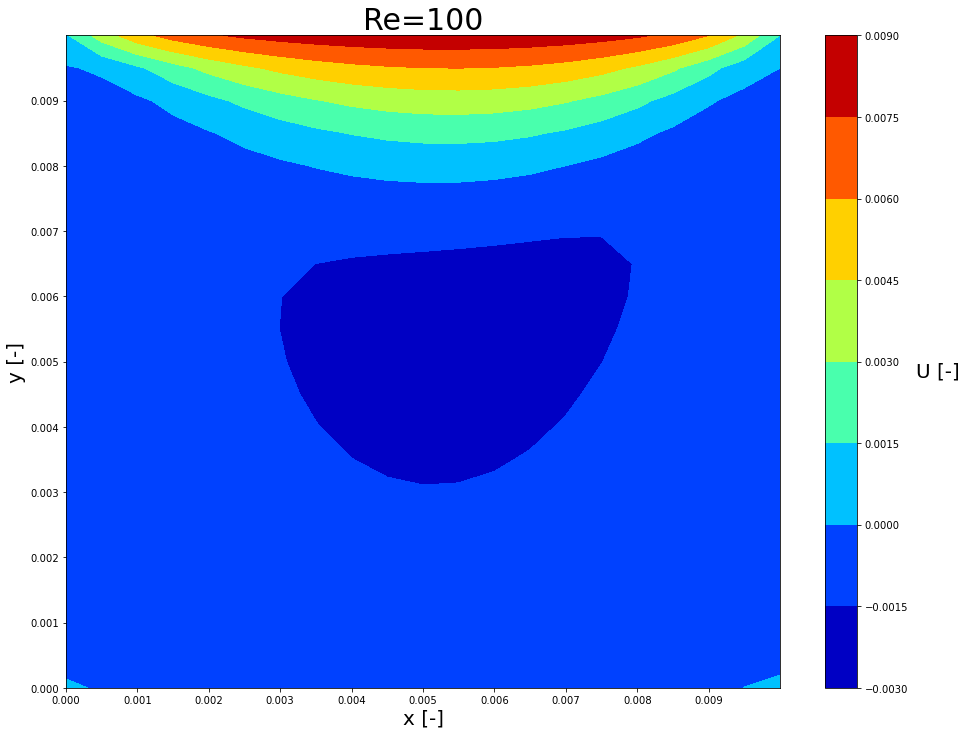

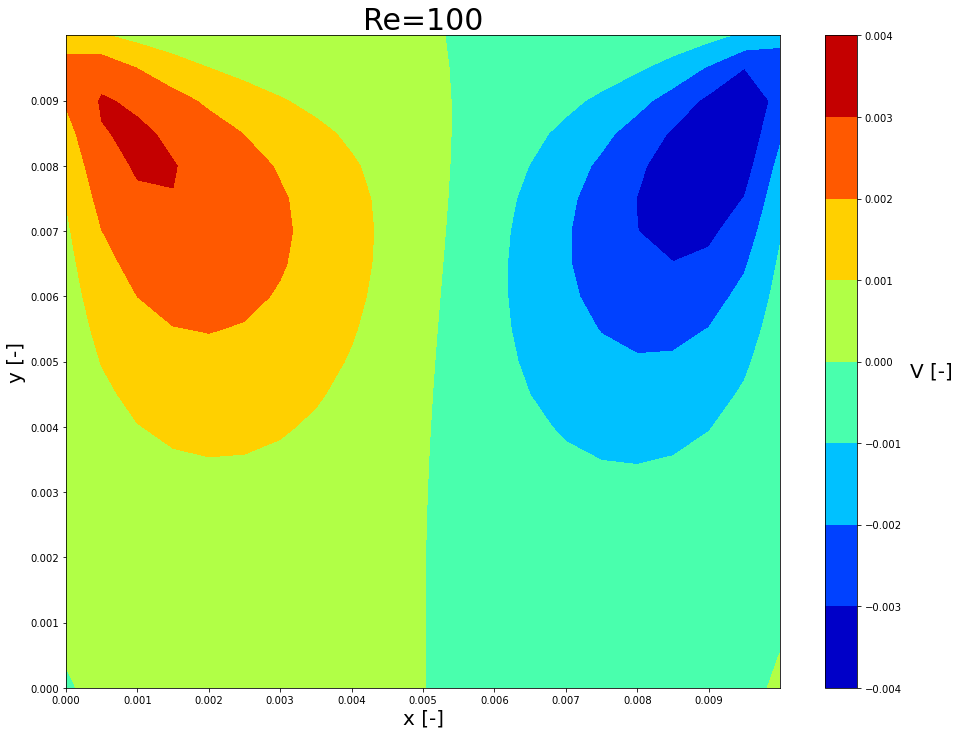

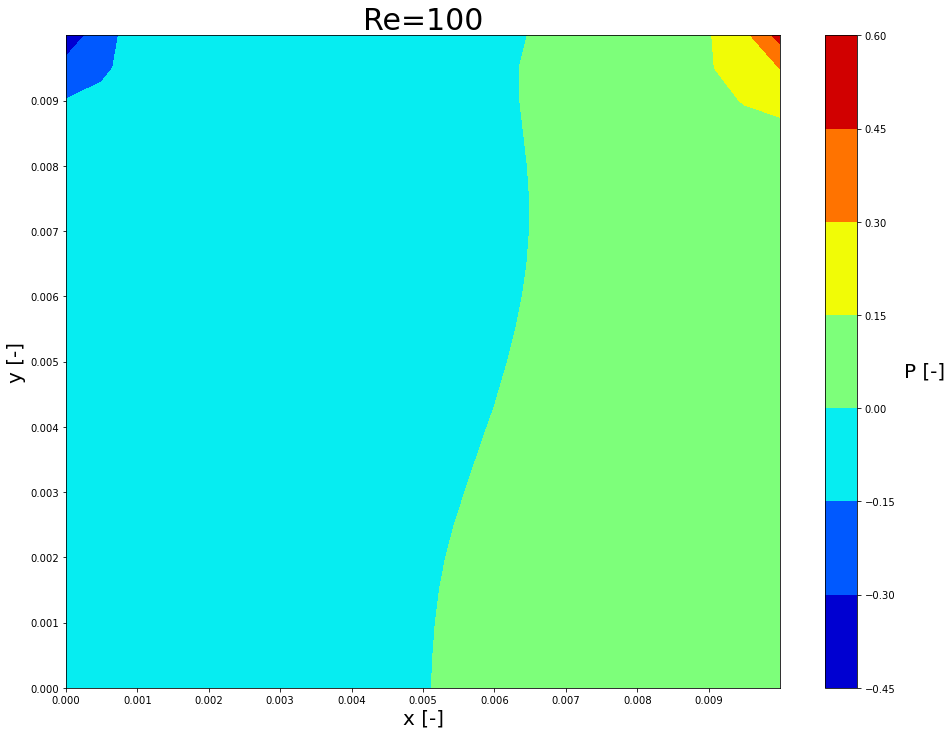

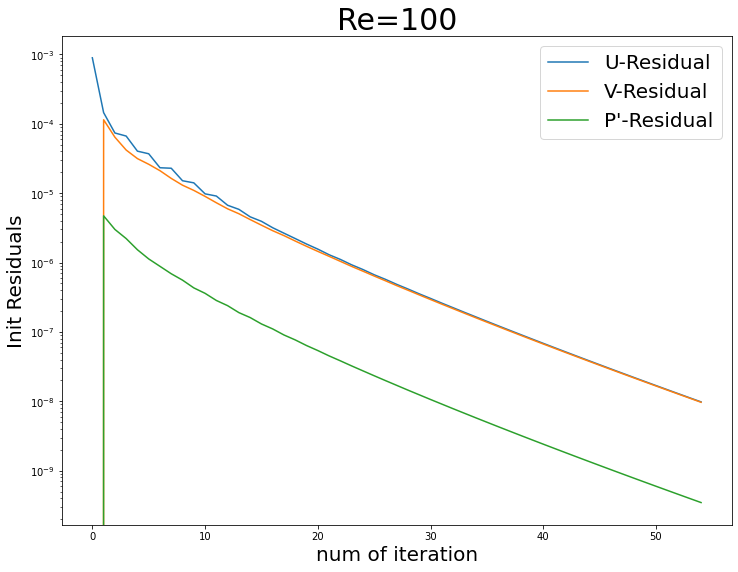

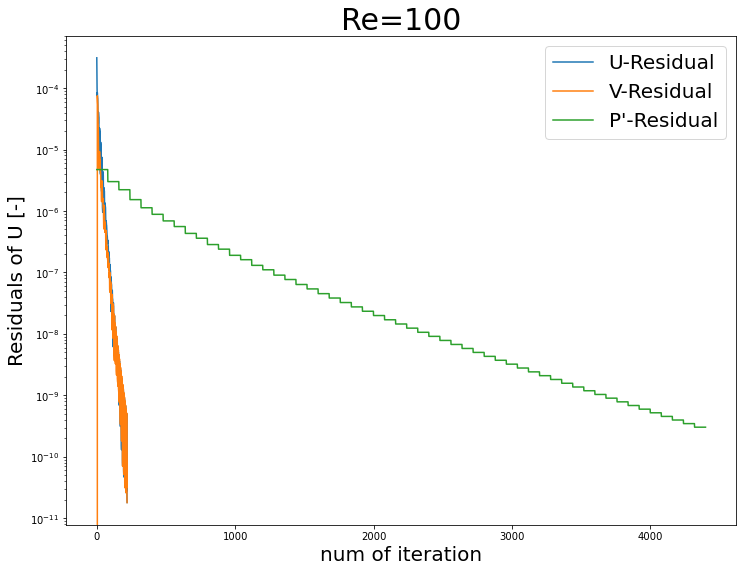

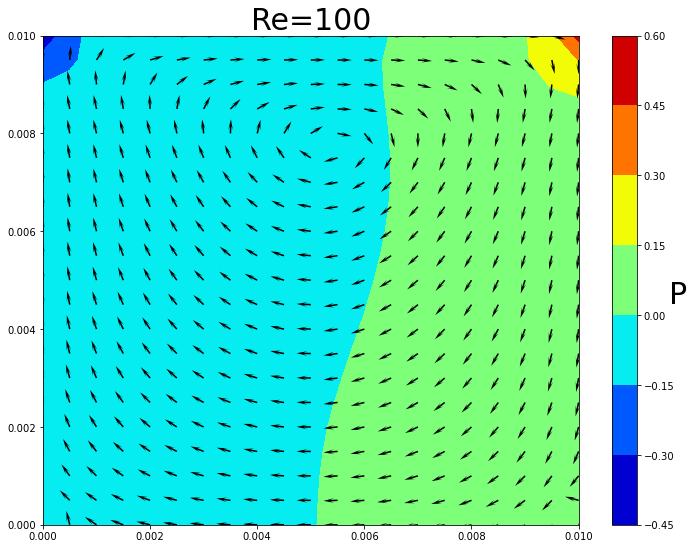

Outer loop:  0
U-Eqn : iter =  4 Init residual =  0.0001788854381999832 , Final residual =  1.5090990573169886e-05 , Solver residual= 0.0002864991192273117
V-Eqn : iter =  4 Init residual =  0.0 , Final residual =  0.0 , Solver residual= 0.0
P-Eqn : iter =  80 Init residual =  0.0  Final residual =  4.715298896325425e-06 , Continuity error= 4.715298896325425e-06
Outer loop:  1
U-Eqn : iter =  4 Init residual =  3.505587597382493e-05 , Final residual =  1.4358511319565134e-05 , Solver residual= 0.00029368102631965735
V-Eqn : iter =  4 Init residual =  2.391265992536399e-05 , Final residual =  1.0815679637935566e-05 , Solver residual= 0.00012950088009676245
P-Eqn : iter =  80 Init residual =  4.715298896325425e-06  Final residual =  3.6728574142249265e-06 , Continuity error= 3.6728574142249265e-06
Outer loop:  2
U-Eqn : iter =  4 Init residual =  2.096845978256454e-05 , Final residual =  5.604699684928013e-06 , Solver residual= 0.0003106620438531807
V-Eqn : iter =  4 Init residual =  1.4

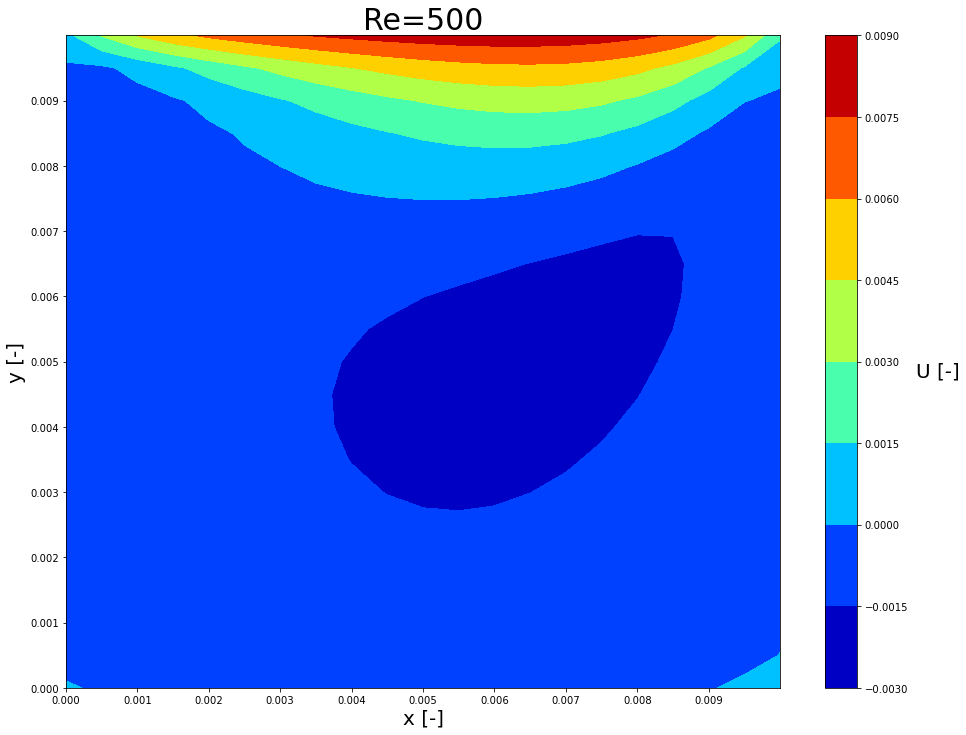

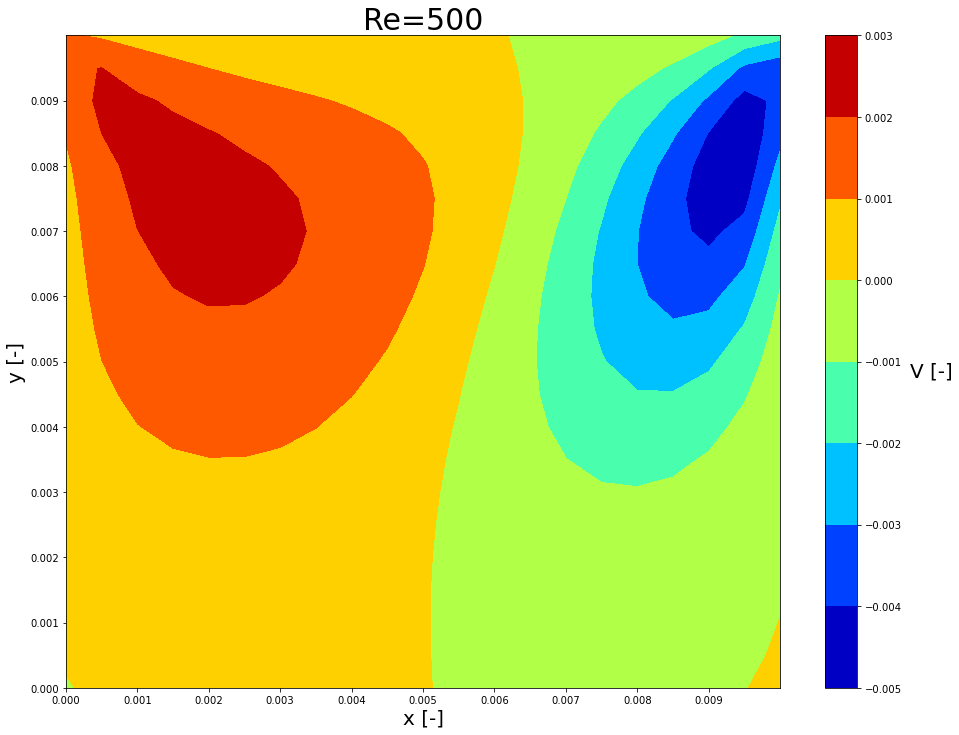

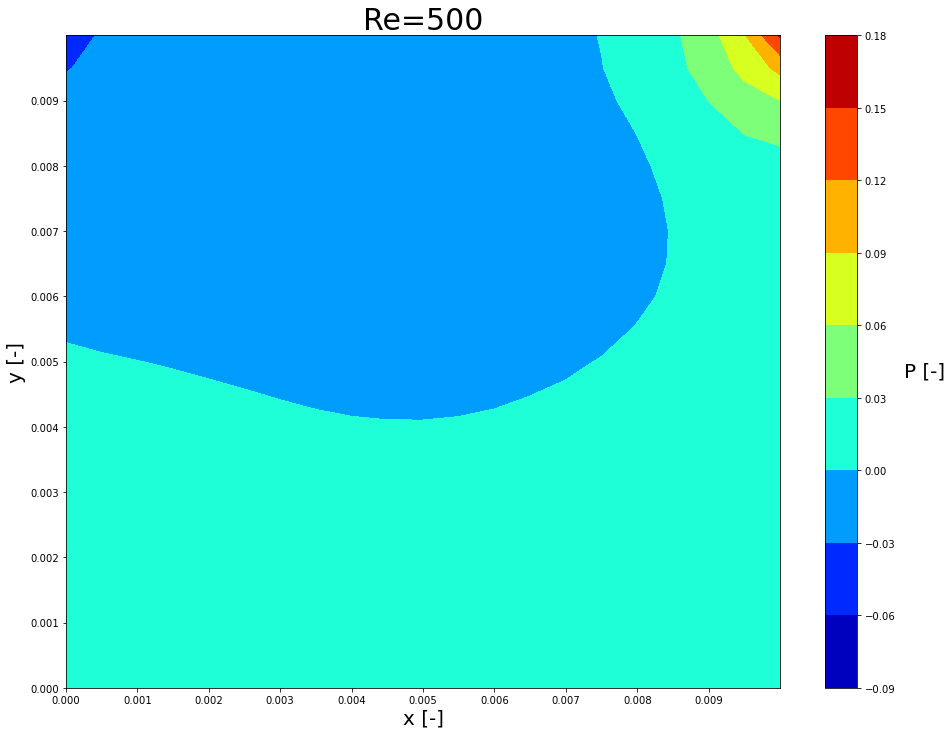

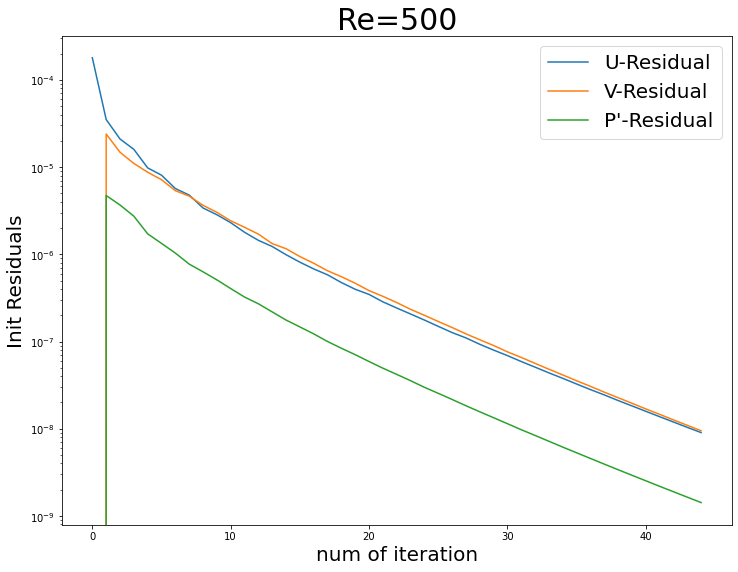

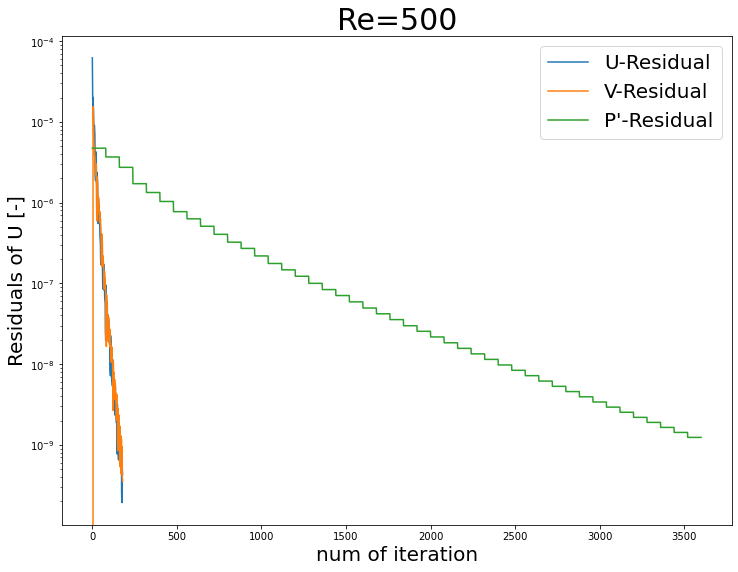

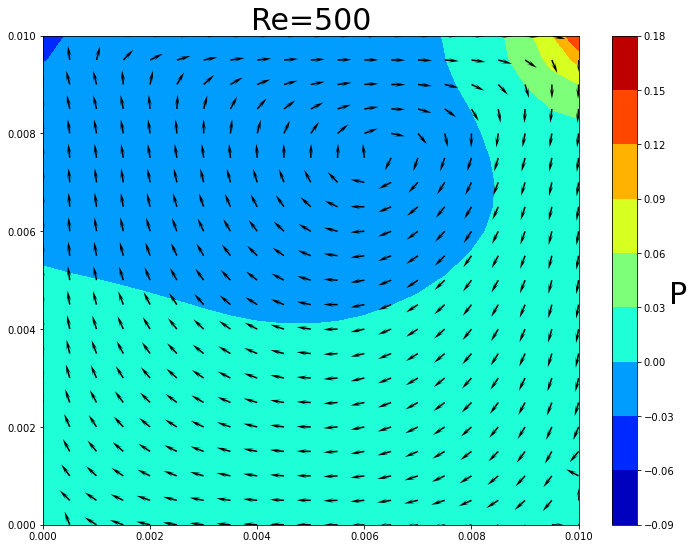

Outer loop:  0
U-Eqn : iter =  4 Init residual =  8.94427190999916e-05 , Final residual =  7.545495286584943e-06 , Solver residual= 0.00014324955961365584
V-Eqn : iter =  4 Init residual =  0.0 , Final residual =  0.0 , Solver residual= 0.0
P-Eqn : iter =  80 Init residual =  0.0  Final residual =  4.715298896325425e-06 , Continuity error= 4.715298896325425e-06
Outer loop:  1
U-Eqn : iter =  4 Init residual =  2.468613881057844e-05 , Final residual =  8.234529705231156e-06 , Solver residual= 0.00016107174221619483
V-Eqn : iter =  4 Init residual =  1.3444184601044243e-05 , Final residual =  5.392885328371803e-06 , Solver residual= 6.681692422076994e-05
P-Eqn : iter =  80 Init residual =  4.715298896325425e-06  Final residual =  4.773759968568247e-06 , Continuity error= 4.773759968568247e-06
Outer loop:  2
U-Eqn : iter =  4 Init residual =  1.3887713904245269e-05 , Final residual =  2.6376841939286593e-06 , Solver residual= 0.00016384007889615586
V-Eqn : iter =  4 Init residual =  9.315

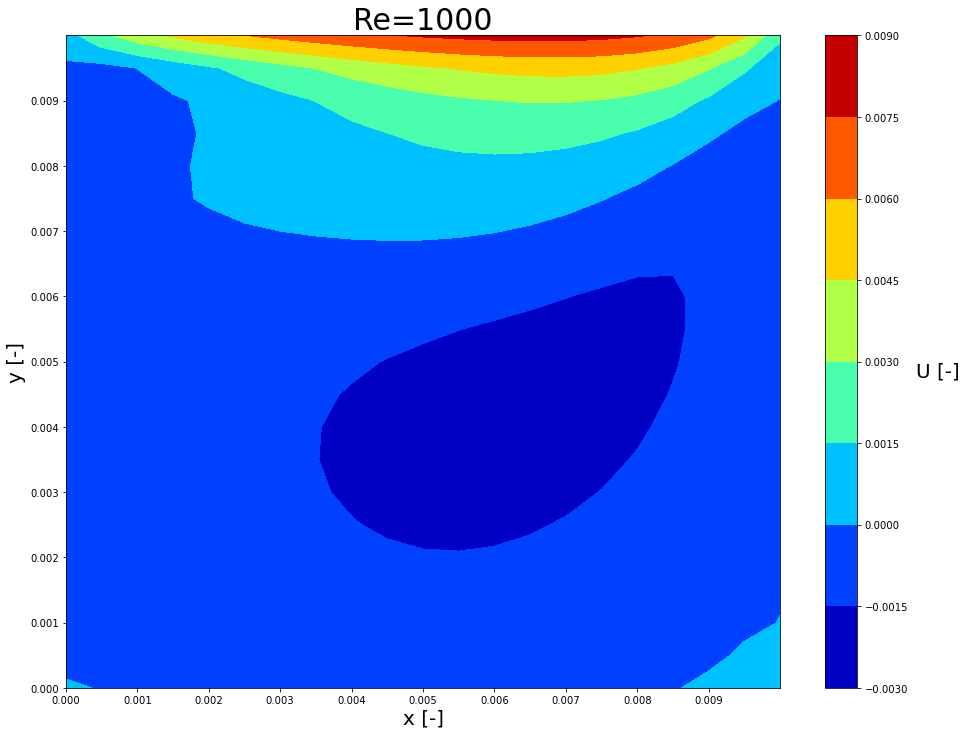

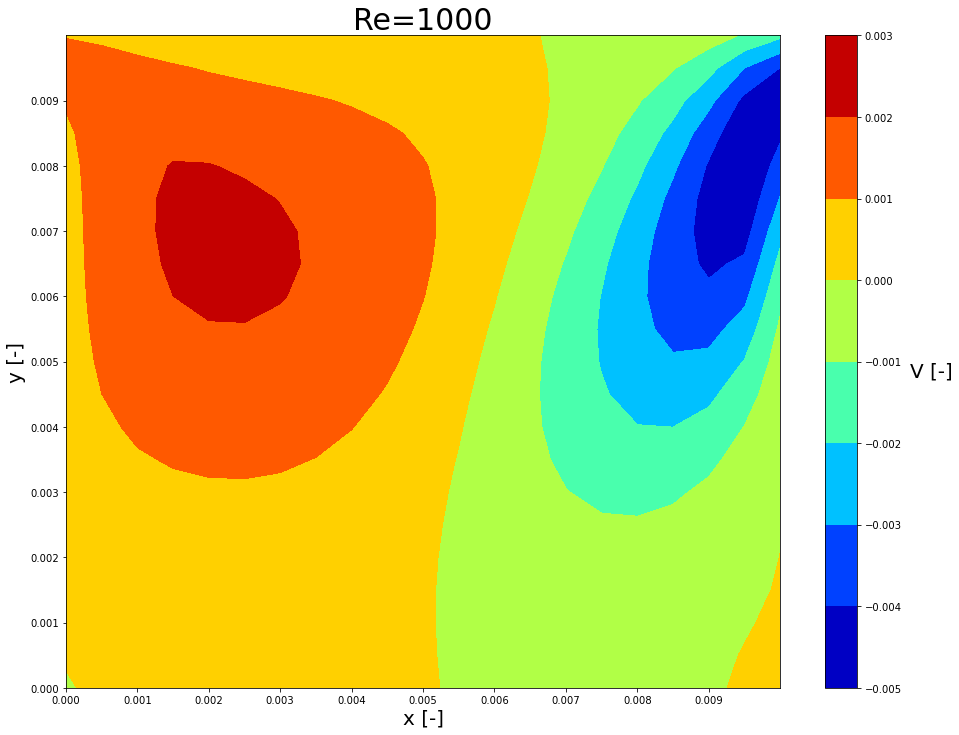

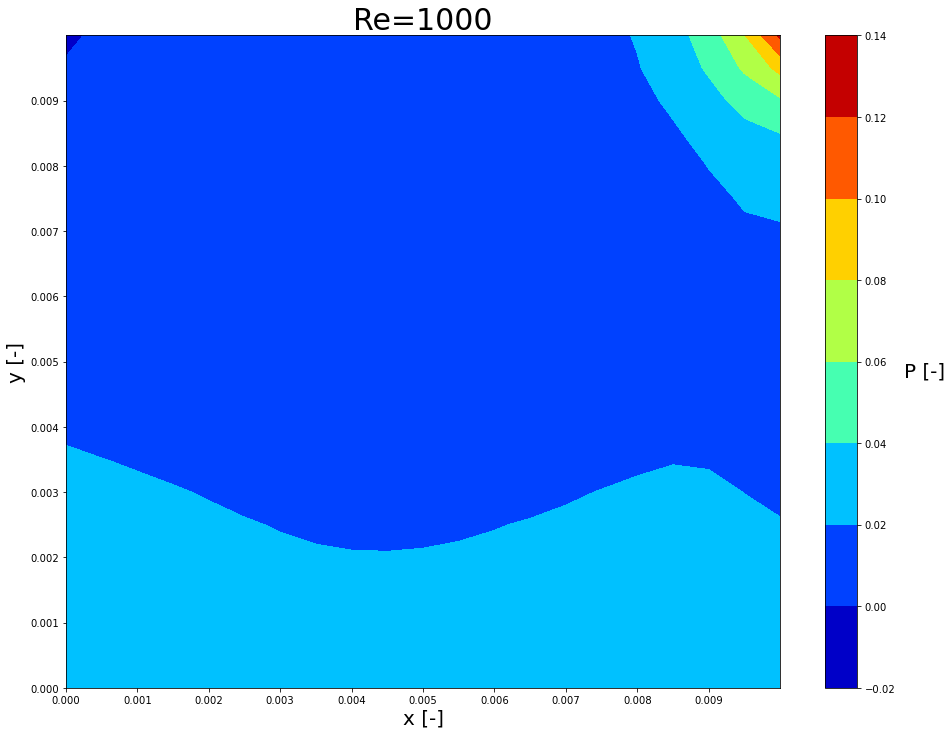

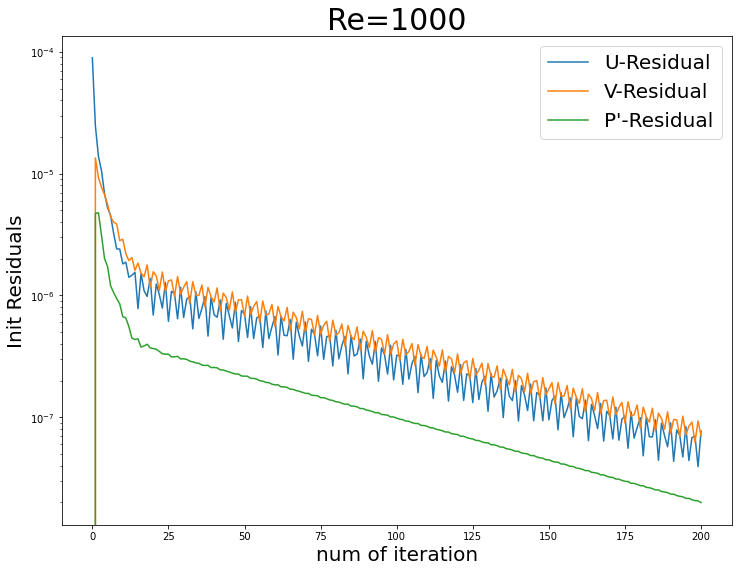

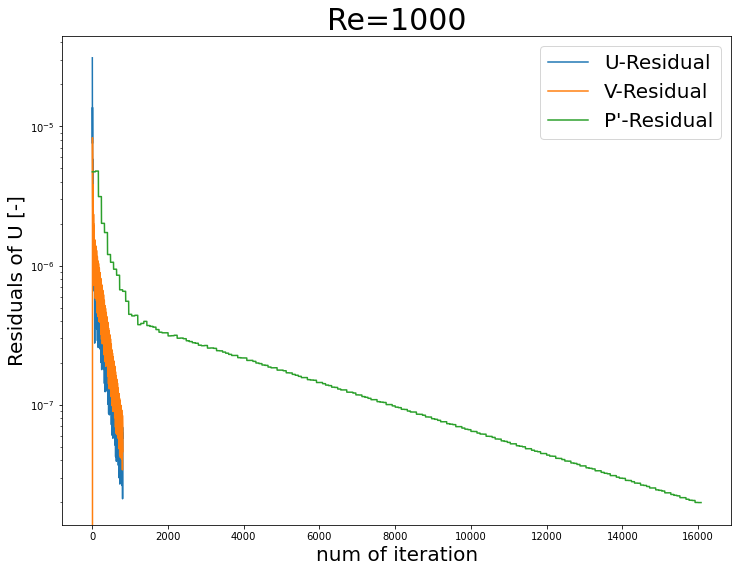

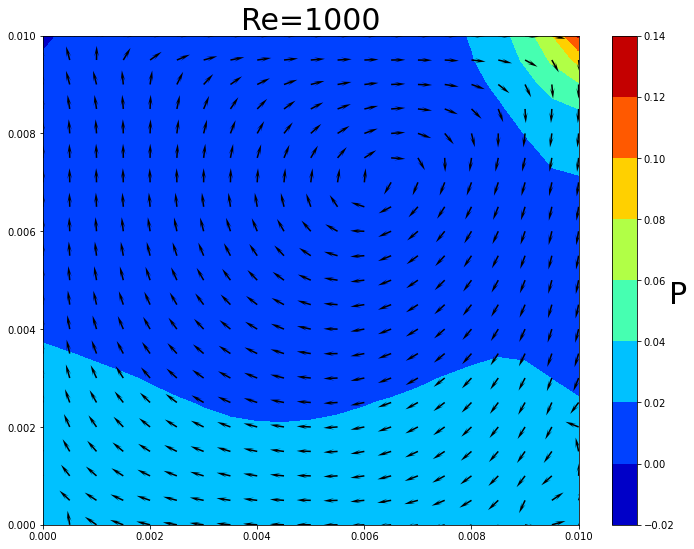

int(nx/2-1)= 10
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
(21,)


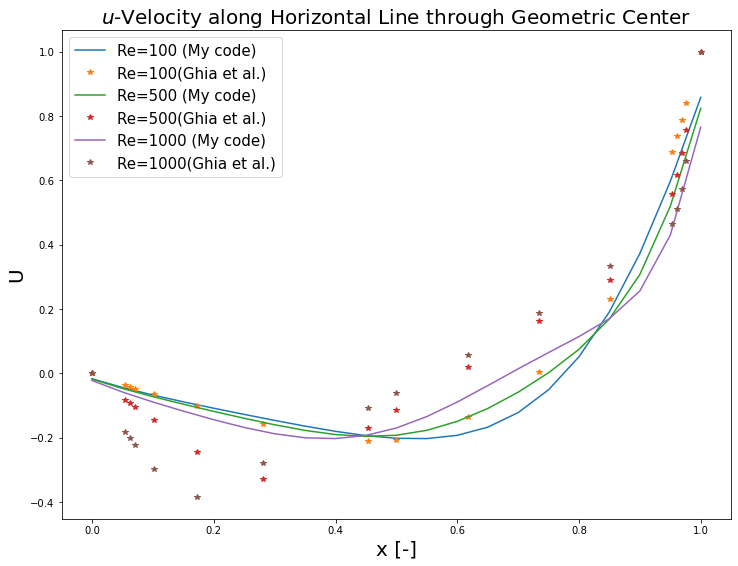

int(ny/2-1)= 10


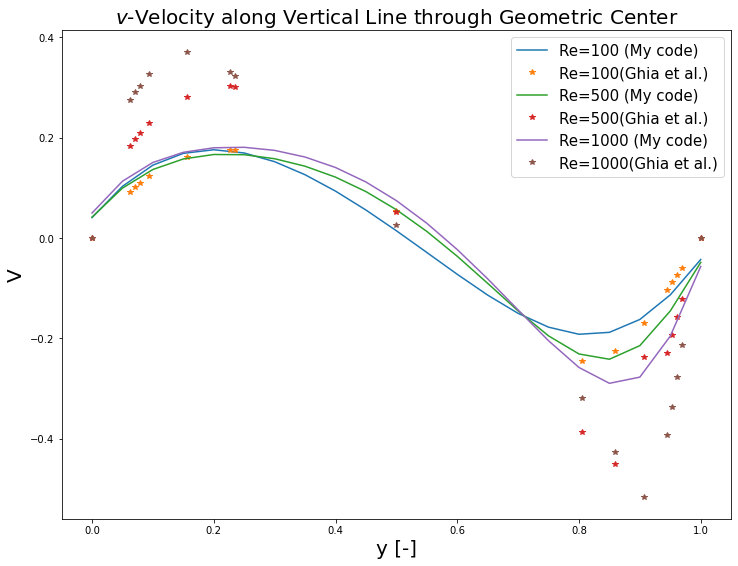

In [9]:
# Main Program
if __name__ == '__main__' :
    tol = 1E-4 # Not used, please ignore
    # MESH
    x0 = 0
    xL = 0.01
    nx = 21 + 1
    xline = np.linspace(x0, xL, nx)
    y0 = 0
    yL = 0.01
    ny = 21 + 1
    yline = np.linspace(y0, yL, ny)
    xmesh, ymesh = np.meshgrid(xline, yline)
    nx = nx - 1
    xline = np.linspace(x0, xL, nx)
    ny = ny - 1
    yline = np.linspace(y0, yL, ny)
    xcmesh, ycmesh = np.meshgrid(xline, yline)
    # Physical Parameters
    Re = [100, 500, 1000]
    Gamma = np.divide(1.0, Re)
    rho = 1
    case_names = ['Re=100', 'Re=500', 'Re=1000']
    bcs = 'cavity'
    uBD = [0.0, 0.0, 0.01, 0.0] # [Left, Right, Top, Bottom]
    vBD = [0.0, 0.0, 0.0, 0.0] # [Left, Right, Top, Bottom]
    # schemes = 'upwind'
    schemes = 'powerlaw'
    # schemes = ['exponential']
    limiters = None

    # SIMPLE parameters
    iter_UV = 4 # Inner loop for UV Eqn
    iter_P = 80 # Inner loop for P Eqn
    outloop_max = 200 # Max iter number of outer loop
    tol_UV = 1E-8 # Convergency criterion of the UV Eqn
    tol_P = 1E-8 # Convergency criterion of the P Eqn
    alpha = 0.2 # damping coefficient for solving u and v momentum equations
    relax_factor_UV = 0.8 # Relaxation factor for UV
    relax_factor_P = 0.2 # Relaxation facto for P
    simple_param = [iter_UV, iter_P, outloop_max, tol_UV, tol_P, alpha, relax_factor_UV, relax_factor_P]
    prefix = os.getcwd() + '/'
    # Test cases:
    sols = []
    for case in range(len(case_names)):
        sols.append(run(case, Gamma[case], rho, simple_param, tol, schemes, limiters, bcs, uBD, vBD, xmesh, ymesh))
        # U plot
        plt.rcParams['figure.figsize'] = (16, 12)
        ct=plt.contourf(xcmesh, ycmesh, sols[case].U, cmap='jet')
        cb=plt.colorbar(ct)
        cb.ax.set_ylabel("        U [-]", rotation=0, fontsize=20)
        plt.xlabel("x [-]", fontsize=20)
        plt.ylabel("y [-]", fontsize=20)
        plt.xticks(np.arange(0,xL,xL/10), fontsize=10)
        plt.yticks(np.arange(0,yL,yL/10), fontsize=10)
        plt.title(case_names[case], fontsize=30)
        plt.savefig(prefix + 'results/' + case_names[case] + '_u.png', dpi=100)
        plt.show()
        # V plot
        plt.rcParams['figure.figsize'] = (16, 12)
        ct=plt.contourf(xcmesh, ycmesh, sols[case].V, cmap='jet')
        cb=plt.colorbar(ct)
        cb.ax.set_ylabel("        V [-]", rotation=0, fontsize=20)
        plt.xlabel("x [-]", fontsize=20)
        plt.ylabel("y [-]", fontsize=20)
        plt.xticks(np.arange(0,xL,xL/10), fontsize=10)
        plt.yticks(np.arange(0,yL,yL/10), fontsize=10)
        plt.title(case_names[case], fontsize=30)
        plt.savefig(prefix + 'results/' + case_names[case] + '_v.png', dpi=100)
        plt.show()
        # P plot
        plt.rcParams['figure.figsize'] = (16, 12)
        ct=plt.contourf(xcmesh, ycmesh, sols[case].P, cmap='jet')
        cb=plt.colorbar(ct)
        cb.ax.set_ylabel("        P [-]", rotation=0, fontsize=20)
        plt.xlabel("x [-]", fontsize=20)
        plt.ylabel("y [-]", fontsize=20)
        plt.xticks(np.arange(0,xL,xL/10), fontsize=10)
        plt.yticks(np.arange(0,yL,yL/10), fontsize=10)
        plt.title(case_names[case], fontsize=30)
        plt.savefig(prefix + 'results/' + case_names[case] + '_p.png', dpi=100)
        plt.show()
        # Init residuals
        plt.rcParams['figure.figsize'] = (12, 9)
        plt.plot(range(len(sols[case].InitResiduals[0])), sols[case].InitResiduals[0], label='U-Residual')
        plt.plot(range(len(sols[case].InitResiduals[1])), sols[case].InitResiduals[1], label='V-Residual')
        plt.plot(range(len(sols[case].InitResiduals[2])), sols[case].InitResiduals[2], label='P\'-Residual')
        plt.legend(fontsize=20)
        plt.xlabel("num of iteration", fontsize=20)
        plt.ylabel("Init Residuals", fontsize=20)
        plt.yscale('log')
        plt.title(case_names[case], fontsize=30)
        plt.savefig(prefix + 'results/' + case_names[case] + '_InitResidualHistory.png', dpi=100)
        plt.show()
        # residuals
        plt.rcParams['figure.figsize'] = (12, 9)
        plt.plot(range(len(sols[case].residuals[0])), sols[case].residuals[0], label='U-Residual')
        plt.plot(range(len(sols[case].residuals[1])), sols[case].residuals[1], label='V-Residual')
        plt.plot(range(len(sols[case].residuals[2])), sols[case].residuals[2], label='P\'-Residual')
        plt.legend(fontsize=20)
        plt.yscale('log')
        plt.xlabel("num of iteration", fontsize=20)
        plt.ylabel("Residuals of U [-]", fontsize=20)
        plt.title(case_names[case], fontsize=30)
        plt.savefig(prefix + 'results/' + case_names[case] + '_residualHistory.png', dpi=100)
        plt.show()
        # Contour Plot
        cp = plt.contourf(xcmesh, ycmesh, sols[case].P, cmap='jet')
        cb = plt.colorbar(cp)
        cb.ax.set_ylabel("P", rotation=0, fontsize=30)
        # Vector Field
        U =sols[case].U
        V =sols[case].V
        speed = np.sqrt(U**2 + V**2)
        UN = U/speed
        VN = V/speed
        quiv = plt.quiver(xcmesh, ycmesh, UN, VN,  # assign to var
                  color='Black', 
                  headlength=7)
        plt.title(case_names[case], fontsize=30)
        plt.savefig(prefix + 'results/' + case_names[case] + '_pressureWithVelVec.png', dpi=100)
        plt.show()
    # Literature data
    u_yPos = [0, 0.0547, 0.0625, 0.0703, 0.1016, 0.1719, 0.2813, 0.4531, 0.5, 0.6172, 0.7344, 0.8516, 0.9531, 0.9609, 0.9688, 0.9766, 1.0]
    u100 =   [0, -0.03717, -0.04192, -0.04775, -0.06434, -0.1015, -0.15662, -0.21090, -0.20581, -0.13641, 0.00332, 0.23151, 0.68717, 0.73722, 0.78871, 0.84123, 1.0]
    u400 =   [0, -0.08186, -0.09266, -0.10338, -0.14612, -0.24299, -0.32726, -0.17119, -0.11477, 0.02135, 0.16256, 0.29093, 0.55892, 0.61756, 0.68439, 0.75837, 1.0]
    u1000 =  [0, -0.18109, -0.20196, -0.2222, -0.2973, -0.38289, -0.27805,-0.10648, -0.0608, 0.05702, 0.18719, 0.33304, 0.46604, 0.51117, 0.57492, 0.65928, 1.0]
    v_xPos = [0, 0.0625, 0.0703, 0.0781, 0.0938, 0.1563, 0.2266, 0.2344, 0.5, 0.8047, 0.8594, 0.9063, 0.9453, 0.9531, 0.9609, 0.9688, 1.0]
    v100 =   [0, 0.09233, 0.10091, 0.1089, 0.12317, 0.16077, 0.17507, 0.17527, 0.05454, -0.24533, -0.22445, -0.16914, -0.10313, -0.08864, -0.07391, -0.05906, 0]
    v400 =   [0, 0.1836, 0.19713, 0.2092, 0.22965, 0.28124, 0.30203, 0.30174, 0.05186, -0.38598, -0.44993, -0.23827, -0.22847, -0.19254, -0.15663, -0.12146, 0]
    v1000 =  [0, 0.27485, 0.29012, 0.30353, 0.32627, 0.37095, 0.33075, 0.32235, 0.02526, -0.31966, -0.42665, -0.5155, -0.39188, -0.33714, -0.27669, -0.21388, 0]
    uRef = [u100, u400, u1000]
    vRef = [v100, v400, v1000]
    # U Comparison
    plt.rcParams['figure.figsize'] = (12, 9)
    print('int(nx/2-1)=',int(nx/2))
    print(np.arange(0,1.01,1/(nx-1)))
    print(np.arange(0,1.01,1/(nx-1)).shape)
    for case in range(len(case_names)):
        # u = 0.5 * (sols[case].U[:,int(nx/2-1)] + sols[case].U[:,int(nx/2)]) / uBD[2]
        u = sols[case].U[:,int(nx/2)] / uBD[2]
        plt.plot(np.arange(0,1.01,1/(nx-1)), u, label=case_names[case] + ' (My code)')
        plt.plot(u_yPos, uRef[case], '*', label=case_names[case] + '(Ghia et al.)')
    plt.legend(fontsize=15)
    plt.ylabel("U", fontsize=20)
    plt.xlabel("x [-]", fontsize=20)
    plt.title('$u$-Velocity along Horizontal Line through Geometric Center', fontsize=20)
    plt.savefig(prefix + 'results/' + case_names[case] + '_UComparison.png', dpi=100)
    plt.show()
    # V Comparison
    plt.rcParams['figure.figsize'] = (12, 9)
    print('int(ny/2-1)=',int(ny/2))
    for case in range(len(case_names)):
        # v = 0.5 * (sols[case].V[int(ny/2-1),:] + sols[case].U[int(ny/2),:]) / uBD[2]
        v = 1.0 * (sols[case].V[int(ny/2),:]) / uBD[2]
        plt.plot(np.arange(0,1.01,1/(ny-1)), v, label=case_names[case] + ' (My code)')
        plt.plot(v_xPos, vRef[case], '*', label=case_names[case] + '(Ghia et al.)')
    plt.legend(fontsize=15)
    plt.ylabel("V", fontsize=20)
    plt.xlabel("y [-]", fontsize=20)
    plt.title('$v$-Velocity along Vertical Line through Geometric Center', fontsize=20)
    plt.savefig(prefix + 'results/' + case_names[case] + '_VComparison.png', dpi=100)
    plt.show()


